## Running Analysis on the Directional Surveys in British Columbia

**Data:** BC Energy Regulator  
**Analysis:** Shahbaz S Mann

#### Cleanup

In [5]:
import pandas as pd
import numpy as   np

dir_df = pd.read_csv('../../assets/dir_survey.csv', skiprows=1, low_memory=False)


dir_df = dir_df.rename(columns={
    'UWI': 'uwi',
    'WA NUM': 'wa_num',
    'Drilling Event': 'drilling_event',
    'Measured Depth (m)': 'md_m',
    'Inclination (deg)': 'inclination_deg',
    'Azimuth (deg)': 'azimuth_deg',
    'TV Depth (m)': 'tvd_m',
    'North South (m)': 'north_south_m',
    'East West (m)': 'east_west_m',
})



dir_df.head(5)

,uwi,wa_num,drilling_event,md_m,inclination_deg,azimuth_deg,tvd_m,north_south_m,east_west_m
0,200B091K094B0802,3488,2,0.0,0.00,0.00,NaN,NaN,NaN
1,200B091K094B0802,3488,2,30.0,0.34,190.39,30.00,-0.09,-0.02
2,200B091K094B0802,3488,2,60.0,0.38,175.04,60.00,-0.27,-0.02
3,200B091K094B0802,3488,2,90.0,0.74,229.44,90.00,-0.50,-0.16
4,200B091K094B0802,3488,2,120.0,1.19,239.55,119.99,-0.78,-0.58


#### Let's see what are the usual TVD's  and MD's of these horizontal wells

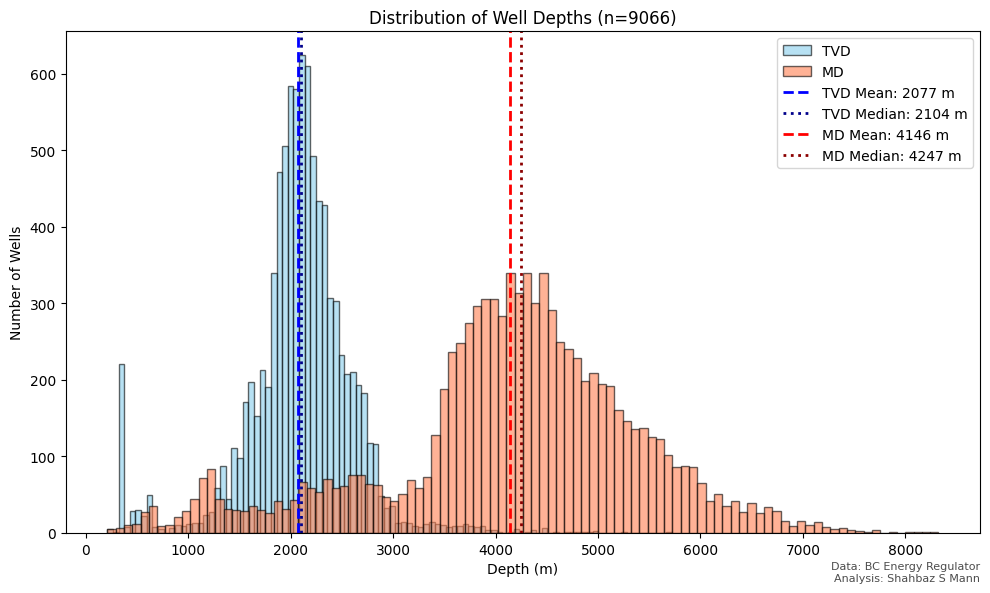

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

depth_cols = ['tvd_m', 'md_m']

well_total_depths = dir_df.groupby('uwi')[depth_cols].max()

mean_tvdepth = well_total_depths['tvd_m'].mean()
median_tvdepth = well_total_depths['tvd_m'].median()

mean_mddepth = well_total_depths['md_m'].mean()
median_mddepth = well_total_depths['md_m'].median()

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(well_total_depths['tvd_m'], bins=100, color='skyblue', edgecolor='black', alpha=0.6, label='TVD')
ax.hist(well_total_depths['md_m'], bins=100, color='coral', edgecolor='black', alpha=0.6, label='MD')

ax.axvline(mean_tvdepth, color='blue', linestyle='dashed', linewidth=2, label=f'TVD Mean: {mean_tvdepth:.0f} m')
ax.axvline(median_tvdepth, color='darkblue', linestyle='dotted', linewidth=2, label=f'TVD Median: {median_tvdepth:.0f} m')

ax.axvline(mean_mddepth, color='red', linestyle='dashed', linewidth=2, label=f'MD Mean: {mean_mddepth:.0f} m')
ax.axvline(median_mddepth, color='darkred', linestyle='dotted', linewidth=2, label=f'MD Median: {median_mddepth:.0f} m')

ax.set_xlabel('Depth (m)')
ax.set_ylabel('Number of Wells')
ax.set_title(f'Distribution of Well Depths (n={len(well_total_depths)})')
ax.legend()

ax.text(1, -0.1, 'Data: BC Energy Regulator\nAnalysis: Shahbaz S Mann', 
        transform=ax.transAxes, fontsize=8, verticalalignment='bottom', 
        horizontalalignment='right', alpha=0.7)

plt.tight_layout()
plt.show()


#### Horizontal Reach Ratio (MD/TVD)
This ratio indicates how much horizontal distance is reached for each unit of vertical depth. Higher ratios indicate more lateral reach.

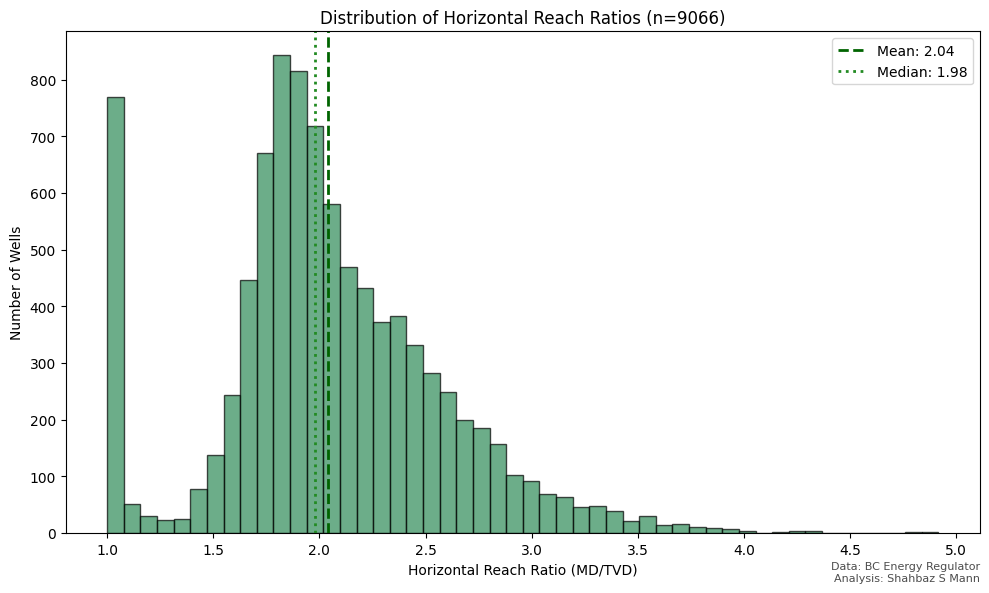

In [7]:

well_total_depths['reach_ratio'] = well_total_depths['md_m'] / well_total_depths['tvd_m']


well_total_depths_clean = well_total_depths[
    (well_total_depths['reach_ratio'] > 0) & 
    (well_total_depths['reach_ratio'] < 10)  
].copy()

mean_ratio = well_total_depths_clean['reach_ratio'].mean()
median_ratio = well_total_depths_clean['reach_ratio'].median()

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(well_total_depths_clean['reach_ratio'], bins=50, color='seagreen', edgecolor='black', alpha=0.7)

ax.axvline(mean_ratio, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_ratio:.2f}')
ax.axvline(median_ratio, color='forestgreen', linestyle='dotted', linewidth=2, label=f'Median: {median_ratio:.2f}')

ax.set_xlabel('Horizontal Reach Ratio (MD/TVD)')
ax.set_ylabel('Number of Wells')
ax.set_title(f'Distribution of Horizontal Reach Ratios (n={len(well_total_depths_clean)})')
ax.legend()

ax.text(1, -0.1, 'Data: BC Energy Regulator\nAnalysis: Shahbaz S Mann', 
        transform=ax.transAxes, fontsize=8, verticalalignment='bottom', 
        horizontalalignment='right', alpha=0.7)

plt.tight_layout()
plt.show()


####  Let's  see how the longest wells' trajectories look

Top 5 wells: ['100010908425W600', '100151907714W600', '100101907714W602', '100070607713W600', '100161707916W600']


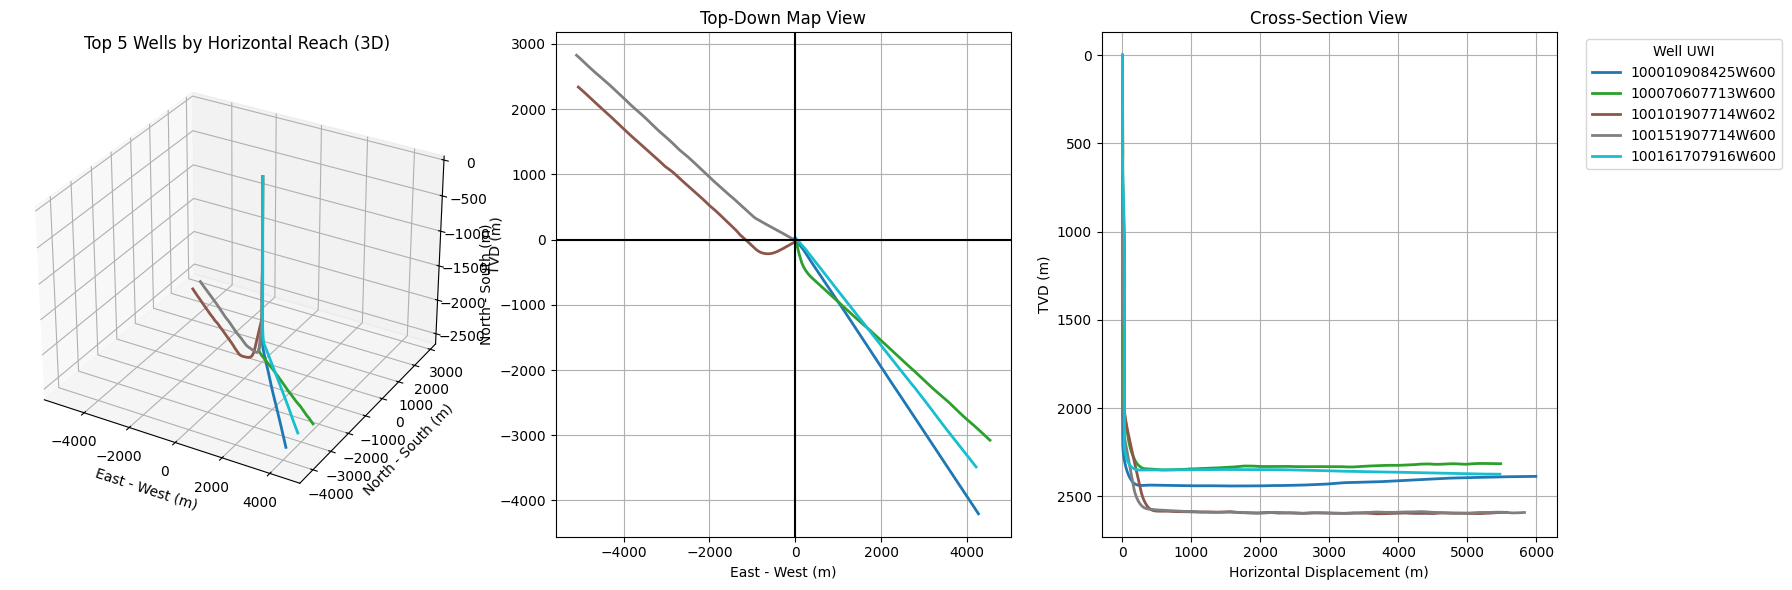

In [8]:
dir_df['displacement'] = np.sqrt(dir_df['north_south_m']**2 + dir_df['east_west_m']**2)


max_reach_per_well = dir_df.groupby('uwi')['displacement'].max()


top_5_uwis = max_reach_per_well.sort_values(ascending=False).head(5).index.tolist()


top_5_df = dir_df[dir_df['uwi'].isin(top_5_uwis)]

print(f"Top 5 wells: {top_5_uwis}")

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

grouped = top_5_df.groupby('uwi')
colors = plt.cm.tab10(np.linspace(0, 1, len(grouped)))

for (uwi, group), color in zip(grouped, colors):
    group = group.sort_values(by='md_m')
    

    ax1.plot(group['east_west_m'], group['north_south_m'], -group['tvd_m'], color=color, linewidth=2, label=uwi)
    
 
    ax2.plot(group['east_west_m'], group['north_south_m'], color=color, linewidth=2, label=uwi)
    

    ax3.plot(group['displacement'], group['tvd_m'], color=color, linewidth=2, label=uwi)


ax1.set_title('Top 5 Wells by Horizontal Reach (3D)')
ax1.set_xlabel('East - West (m)'); ax1.set_ylabel('North - South (m)'); ax1.set_zlabel('TVD (m)')

ax2.set_title('Top-Down Map View')
ax2.set_xlabel('East - West (m)'); ax2.set_ylabel('North - South (m)')
ax2.grid(True); ax2.axhline(0, color='black'); ax2.axvline(0, color='black')

ax3.set_title('Cross-Section View')
ax3.set_xlabel('Horizontal Displacement (m)'); ax3.set_ylabel('TVD (m)')
ax3.invert_yaxis(); ax3.grid(True)
ax3.legend(title="Well UWI", bbox_to_anchor=(1.05, 1), loc='upper left')


ax.text(1, -0.1, 'Data: BC Energy Regulator\nAnalysis: Shahbaz S Mann', 
        transform=ax.transAxes, fontsize=8, verticalalignment='bottom', 
        horizontalalignment='right', alpha=0.7)

plt.tight_layout()
plt.show()